# Estimating disparity maps for stereo images

In this recipe, you will learn how to compute a disparity map from two rectified images. This functionality is useful in many computer vision applications where you need to recover information about depth in a scene, for example, collision avoidance in advanced driver assistance applications.

We use two different algorithms for disparity maps calculation—block matching and semi-global block matching. After the map estimation object is instantiated using either `cv2.StereoBM_create`  or `cv2.StereoSGBM_create` (where we specify maximum possible disparity), we call the compute method, which takes two images and returns a disparity map.

Note that it's necessary to pass rectified images as input to the `compute` method. The returned disparity map will contain per-pixel disparity values, for example, a horizontal offset in pixels between the left and right image points corresponding to the same point in the scene. That offset then can be used to restore an actual point in 3D.

*When creating a disparity estimator, you can specify a number of parameters specific to the algorithm used. For a more detailed description, you can refer to OpenCV's documentation on this: 
https://docs.opencv.org/master/d9/d0c/group__calib3d.html.*
 
*There's also a module called cudastereo available in OpenCV that was built with CUDA support, which provides more optimized stereo algorithms. You can also check out the stereo module in the OpenCV contrib repository, which also contains a few additional algorithms.*

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import imutils
import os

%matplotlib auto
%pylab inline

def print_image(header,name,np_arr,
                start_First=0,end_First=1,start_Second=0,end_Second=2,start_3=0,end_3=5):
    print("------  {0:-<25}    Shape{1} {2}: {3:}".format(header, np_arr.shape, name, str(np_arr.dtype)) )
    shapes = np_arr.shape #print(shapes)
    if shapes[0] < end_First:
        end_First = shapes[0]
    if shapes[1] < end_Second:
        end_Second = shapes[1]
    if len(shapes)==3:
        if shapes[2] < end_3:
            end_3 = shapes[2]
    if len(shapes)==3:
        for i in range (start_First,end_First):
            print("[", sep='',end="")
            for j in range (start_Second,end_Second):
                print(np_arr[i,j,start_3:end_3], sep=' ', end=" ")
            print(']')
    if len(shapes)==2:
        for i in range (start_First,end_First):
            print("[", end=" ")
            #print(np_arr[i,start_Second:end_Second],sep=' ',end=" ") cutoff sting by<60
            for k in range (start_Second,end_Second):
                print(np_arr[i,k], end=" ")
            print(']')

def draw_grid(img, pxystep=None,major_color=None, pxstep=None,pystep=None):
    #print("{0} XY{1} color{2} X{3} Y{4}".format(img.shape, pxystep,major_color,pxstep,pystep))
    pXYstep = None; pXstep=None; pYstep=None; 
    major_Color=None; minor_Color=None; major_Alpha=None; minor_Alpha=None;
    if pxystep != None:
        pXYstep = pXstep = pYstep = pxystep;
    else:
        pXstep = pxstep if pxstep != None else 100
        pYstep = pystep if pystep != None else 100
    major_Color = major_color if major_color != None else (204, 204, 204) #'#CCCCCC'
    if pXstep != None:
        x = pXstep
        #Draw all lines on X
        while x < img.shape[1]:
            cv2.line(img, (x, 0), (x, img.shape[0]), color=major_Color, thickness=1)
            x += pXstep
    if pYstep != None:
        y = pYstep
        #Draw all lines on Y
        while y < img.shape[0]:
            cv2.line(img, (0, y), (img.shape[1], y), color=major_Color,thickness=1)
            y += pYstep
    return img

def plt_view_image(plt,list_images,figsize=(15,6), axis="off", cmap='gray'):
    plt.figure(figsize=figsize)
    n = len(list_images)  #; print(n)
    plot_number = 1
    for name, img in list_images:
        plt.subplot(1,n,plot_number)
        plt.axis(axis); plt.title(name)
        if cmap =='gray': plt.imshow(img,cmap='gray' )
        else: plt.imshow(img)
        plot_number = plot_number + 1
    plt.show()

def plt_view_grid(plt, axis ='off',
                  xy_sizeaxis =None,
                  xy_measuare =None,
                  x_min=-10, x_max=10, y_min=-10, y_max=10,
                  x_major_size=1, x_minor_size=0.2, y_major_size=1, y_minor_size=0.2,
                  major_color='#CCCCCC', major_alpha=0.5,
                  minor_color='#CCCCCC', minor_alpha=0.2
                 ):
    if xy_sizeaxis is None:  x_min=-10; x_max=10; y_min=-10; y_max=10;
    else: x_min, x_max, y_min, y_max = xy_sizeaxis

    if xy_measuare is None:  x_major_size=1; x_minor_size=0.2; y_major_size=1; y_minor_size=0.2;
    else: x_major_size, x_minor_size, y_major_size, y_minor_size = xy_measuare
        
    plt.xlim(x_min, x_max); plt.ylim(y_min, y_max);
    ax = plt.gca()
    x_major_ticks=np.arange(x_min,x_max,x_major_size); x_minor_ticks=np.arange(x_min,x_max,x_minor_size)
    y_major_ticks=np.arange(y_min,y_max,y_major_size); y_minor_ticks=np.arange(y_min,y_max,y_minor_size)
    ax.set_xticks(x_major_ticks)
    ax.xaxis.set_major_locator(MultipleLocator(x_major_size))
    ax.set_xticks(x_minor_ticks, minor=True)
    ax.set_yticks(y_major_ticks)
    ax.yaxis.set_major_locator(MultipleLocator(y_major_size))
    ax.set_yticks(y_minor_ticks, minor=True)
    plt.grid(which='major', color=major_color, alpha=major_alpha)
    plt.grid(which='minor', color=minor_color, alpha=minor_alpha)
    #plt.gca().invert_yaxis() plt.gca().invert_xaxis()
    
#help("modules")   
import sys             
print('\n'.join(sys.path))
print("current folder ==",os.getcwd())
#pip list

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib
D:\HTML_DOC\Program\opencv\Packt\S09\env
C:\Program Files\Python38\python38.zip
C:\Program Files\Python38\DLLs
C:\Program Files\Python38\lib
C:\Program Files\Python38
d:\html_doc\program\opencv\packt\s09\env

d:\html_doc\program\opencv\packt\s09\env\lib\site-packages
d:\html_doc\program\opencv\packt\s09\env\lib\site-packages\pip-20.1-py3.8.egg
d:\html_doc\program\opencv\packt\s09\env\lib\site-packages\win32
d:\html_doc\program\opencv\packt\s09\env\lib\site-packages\win32\lib
d:\html_doc\program\opencv\packt\s09\env\lib\site-packages\Pythonwin
d:\html_doc\program\opencv\packt\s09\env\lib\site-packages\IPython\extensions
C:\Users\polit\.ipython
current folder == D:\HTML_DOC\Program\opencv\Packt\S09\env


------  ddata/stereo/left.png----    Shape(288, 384, 3) image_left: uint8
[[1 2 1] [1 4 1] [1 4 1] [1 4 2] [2 4 2] [1 4 1] [1 4 1] ]
[[1 3 1] [2 6 2] [1 5 2] [2 6 2] [2 6 2] [2 6 2] [2 6 2] ]
------  data/stereo/right.png----    Shape(288, 384, 3) image_right: uint8
[[1 2 1] [1 4 1] [1 4 1] [1 4 1] [1 4 1] [1 4 1] [2 4 1] ]
[[1 3 1] [2 6 2] [2 6 1] [2 6 2] [2 6 2] [2 6 2] [2 6 2] ]


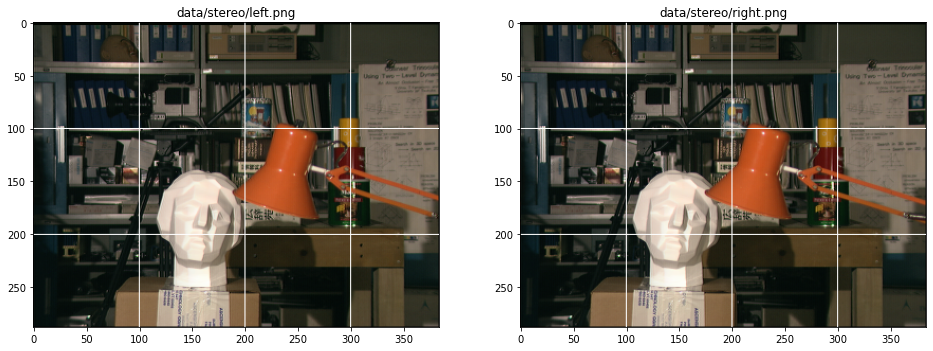

In [2]:
image_left  = cv2.imread('data/stereo/left.png')
image_right = cv2.imread('data/stereo/right.png')



#############################################################
print_image('ddata/stereo/left.png','image_left',image_left,0,2,0,7)
print_image('data/stereo/right.png','image_right',image_right,0,2,0,7)
plt_view_image(plt,[["data/stereo/left.png",  
                     draw_grid(np.copy(image_left),100,(255,255,255))[:,:,[2,1,0]]],
                    ["data/stereo/right.png", 
                     draw_grid(np.copy(image_right),100,(255,255,255))[:,:,[2,1,0]]]],
               figsize=(16,8), axis='on', cmap='gray')

In [3]:
stereo_bm = cv2.StereoBM_create(32)
dispmap_bm = stereo_bm.compute(cv2.cvtColor(image_left, cv2.COLOR_BGR2GRAY), 
                               cv2.cvtColor(image_right, cv2.COLOR_BGR2GRAY))

stereo_sgbm  = cv2.StereoSGBM_create(0, 32)
dispmap_sgbm = stereo_sgbm.compute(image_left, image_right)

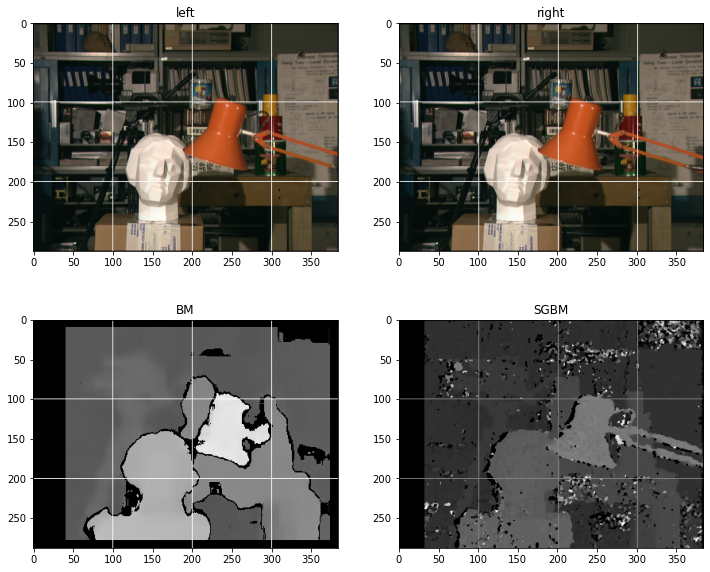

In [4]:
plt.figure(figsize=(12,10))
plt.subplot(221)
plt.title('left')
plt.imshow(draw_grid(np.copy(image_left),100,(255,255,255))[:,:,[2,1,0]])
plt.subplot(222)
plt.title('right')
plt.imshow(draw_grid(np.copy(image_right),100,(255,255,255))[:,:,[2,1,0]])
plt.subplot(223)
plt.title('BM')
plt.imshow(draw_grid(np.copy(dispmap_bm),100,(255,255,255)), cmap='gray')
plt.subplot(224)
plt.title('SGBM')
plt.imshow(draw_grid(np.copy(dispmap_sgbm),100,(255,255,255)), cmap='gray')
plt.show()